Import necessary libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
import time
import tensorflow as tf

In [2]:
train_df =pd.read_csv('DB/Train_data.csv')
test_df =pd.read_csv('DB/Test_data.csv')

In [3]:
train_df.shape


(25192, 42)

In [4]:
test_df.shape

(22544, 41)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [6]:
train_df.isna().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [7]:
train_df.duplicated().sum()

0

<Axes: xlabel='class', ylabel='count'>

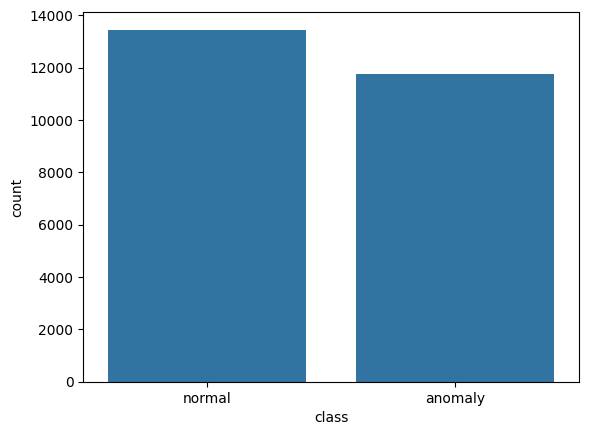

In [8]:
sns.countplot(x=train_df['class'])

In [9]:
train_df['class'].value_counts()

class
normal     13449
anomaly    11743
Name: count, dtype: int64

In [10]:
def label_encoding_df(df):
    for col in df :
        if df[col].dtype=='object':
            le =LabelEncoder()
            df[col] = le.fit_transform(df[col])

label_encoding_df(train_df)
        

In [11]:
X_train = train_df.drop('class' ,axis=1)
y_train = train_df['class']

Selection important features


In [12]:
rf = RandomForestClassifier()

rfe = RFE(rf, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

rf.fit(X_train, y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
rfe_features = [v for i, v in feature_map if i == True]

importances = rf.feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

rfe_importances = feature_importances[feature_importances['Feature'].isin(rfe_features)]



print("RFE-selected features and their importances:")
print(rfe_importances)

print(rfe_features)

RFE-selected features and their importances:
                   Feature  Importance
4                src_bytes    0.178787
5                dst_bytes    0.129526
3                     flag    0.081490
33  dst_host_same_srv_rate    0.069848
29           diff_srv_rate    0.067623
28           same_srv_rate    0.063800
1            protocol_type    0.036791
32      dst_host_srv_count    0.034559
22                   count    0.033973
2                  service    0.022198
['protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate']


In [13]:

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Random forest-selected features and their importances:")
print(feature_importances)

tree_features = feature_importances['Feature'].head(10).tolist()
print(tree_features)

Random forest-selected features and their importances:
                        Feature  Importance
4                     src_bytes    0.192782
5                     dst_bytes    0.103424
28                same_srv_rate    0.072913
3                          flag    0.067566
32           dst_host_srv_count    0.066673
33       dst_host_same_srv_rate    0.063099
11                    logged_in    0.043157
29                diff_srv_rate    0.034761
22                        count    0.033314
24                  serror_rate    0.033281
34       dst_host_diff_srv_rate    0.032665
1                 protocol_type    0.032486
25              srv_serror_rate    0.029465
35  dst_host_same_src_port_rate    0.027699
2                       service    0.024101
36  dst_host_srv_diff_host_rate    0.022819
23                    srv_count    0.017073
37         dst_host_serror_rate    0.016941
39         dst_host_rerror_rate    0.015698
31               dst_host_count    0.013308
38     dst_host_srv_s

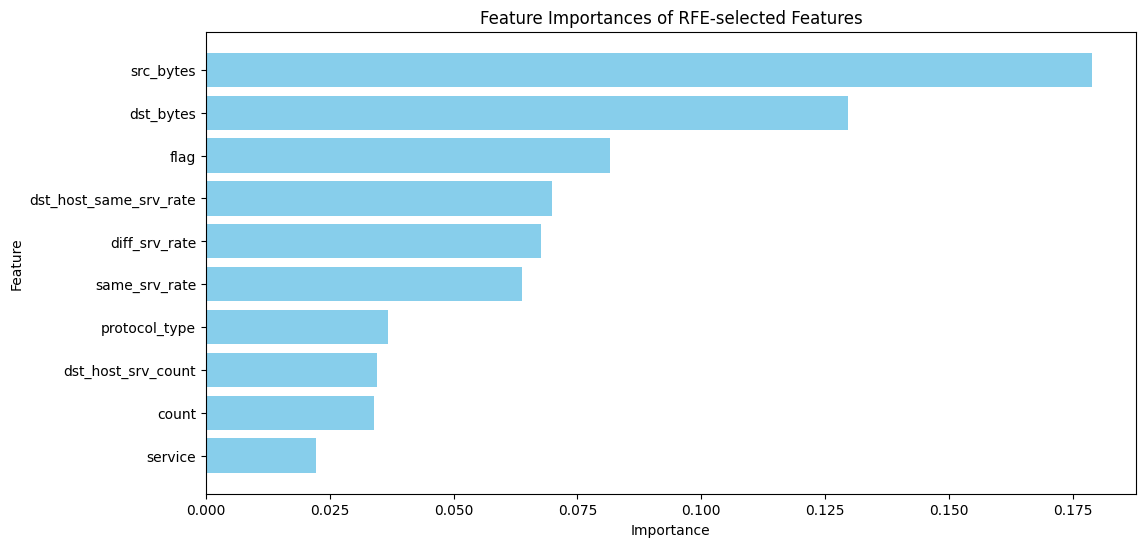

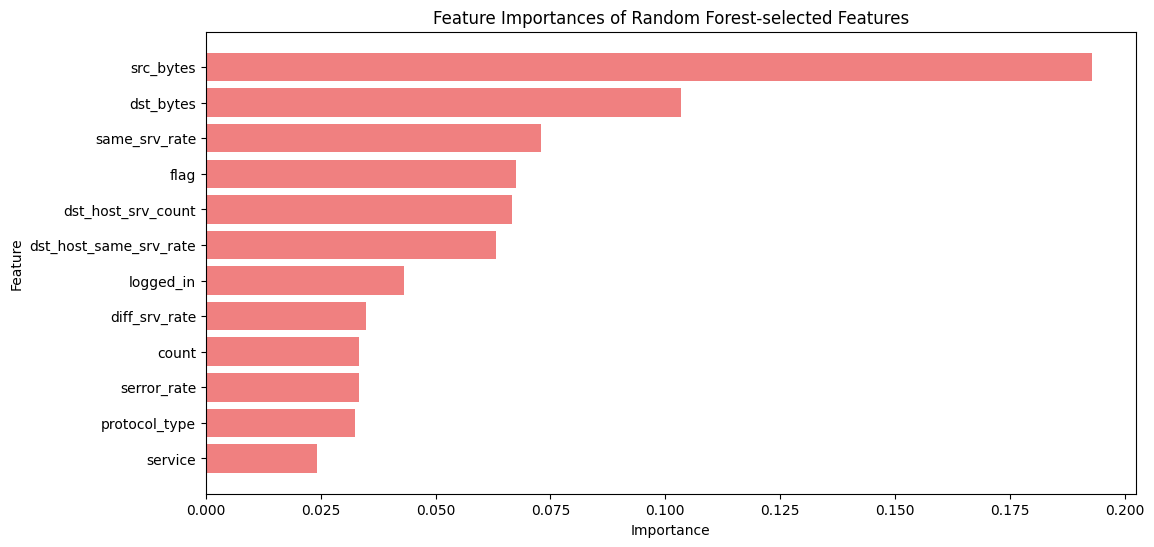

In [14]:

plt.figure(figsize=(12, 6))
plt.barh(rfe_importances['Feature'], rfe_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of RFE-selected Features')
plt.gca().invert_yaxis()
plt.show()

rf_importances = feature_importances[feature_importances['Feature'].isin(rfe_features + ['logged_in', 'serror_rate'])]

plt.figure(figsize=(12, 6))
plt.barh(rf_importances['Feature'], rf_importances['Importance'], color='lightcoral')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest-selected Features')
plt.gca().invert_yaxis()
plt.show()

In [15]:
features = list(set(tree_features + rfe_features))

In [16]:
features

['serror_rate',
 'same_srv_rate',
 'logged_in',
 'dst_host_srv_count',
 'flag',
 'protocol_type',
 'service',
 'count',
 'dst_host_same_srv_rate',
 'diff_srv_rate',
 'src_bytes',
 'dst_bytes']

In [17]:
X = X_train[features]
y = train_df['class']

In [18]:
X_train[features].shape


(25192, 12)

In [19]:
y.shape

(25192,)

In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=2)

In [21]:

candidate_dense_layers = [1, 2, 3, 4, 5]

best_accuracy = 0
best_num_dense_layers = None

for num_dense_layers in candidate_dense_layers:
    model = Sequential()
    
    model.add(Dense(units=64, activation='relu', input_dim=x_train.shape[1]))
    
    for _ in range(num_dense_layers):
        model.add(Dense(units=64, activation='relu'))
    
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    

    model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    y_pred = (model.predict(x_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Number of Dense Layers: {num_dense_layers}, Accuracy: {accuracy}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_num_dense_layers = num_dense_layers

print(f"Best Number of Dense Layers: {best_num_dense_layers}, Best Accuracy: {best_accuracy}")

237/237 [==============================] - 0s 2ms/step
Number of Dense Layers: 1, Accuracy: 0.9747287642233395
237/237 [==============================] - 0s 2ms/step
Number of Dense Layers: 2, Accuracy: 0.9798888594866367
237/237 [==============================] - 0s 2ms/step
Number of Dense Layers: 3, Accuracy: 0.977639587192379
237/237 [==============================] - 0s 2ms/step
Number of Dense Layers: 4, Accuracy: 0.9759195554379465
237/237 [==============================] - 0s 2ms/step
Number of Dense Layers: 5, Accuracy: 0.9779042074622916
Best Number of Dense Layers: 2, Best Accuracy: 0.9798888594866367


In [22]:
data_log = "3-final-kdd_data-{}".format(int(time.time()))
model = Sequential()


model.add(Dense(units=64, activation='relu', input_dim=x_train.shape[1]))


for _ in range(3):
    model.add(Dense(units=64, activation='relu'))


model.add(Dense(units=1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

'''monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=5, verbose=1, mode='auto',
                           restore_best_weights=True)'''
tensorboard = TensorBoard(log_dir="logs/{}".format(data_log))
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1,callbacks=[tensorboard])


accuracy = model.evaluate(x_test, y_test)[1]
print(f"Accuracy : {accuracy}")

Epoch 1/100
552/552 [==============================] - 3s 5ms/step - loss: 0.1293 - accuracy: 0.9599
Epoch 2/100
552/552 [==============================] - 2s 5ms/step - loss: 0.0920 - accuracy: 0.9695
Epoch 3/100
552/552 [==============================] - 3s 5ms/step - loss: 0.0841 - accuracy: 0.9715
Epoch 4/100
552/552 [==============================] - 3s 5ms/step - loss: 0.0822 - accuracy: 0.9718
Epoch 5/100
552/552 [==============================] - 3s 5ms/step - loss: 0.0784 - accuracy: 0.9731
Epoch 6/100
552/552 [==============================] - 3s 5ms/step - loss: 0.0748 - accuracy: 0.9730
Epoch 7/100
552/552 [==============================] - 3s 5ms/step - loss: 0.0731 - accuracy: 0.9747
Epoch 8/100
552/552 [==============================] - 3s 5ms/step - loss: 0.0698 - accuracy: 0.9758
Epoch 9/100
552/552 [==============================] - 2s 4ms/step - loss: 0.0671 - accuracy: 0.9779
Epoch 10/100
552/552 [==============================] - 3s 5ms/step - loss: 0.0663 - accura

In [23]:
model.save('ids_v0.h5')